![Airbnb logo](https://japanesquest.com/wp-content/uploads/2017/10/airbnb-logo.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


# Machine Learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
clean_sum_listings = pd.read_csv('clean_sum_listings.csv')

In [3]:
clean_sum_listings.columns

Index(['Unnamed: 0', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### 1. Feature Transformation

### 1.1 Log Transformation

Since the target variable has a highly skewed distribution - which can cause problems for machine learning algorithms such as linear regression -  following up to the removal of outliers via IQR transformation, a logaritmic transformation should help the distribution get closer to normal.

Text(0.5, 1.0, 'Log Price Distribution')

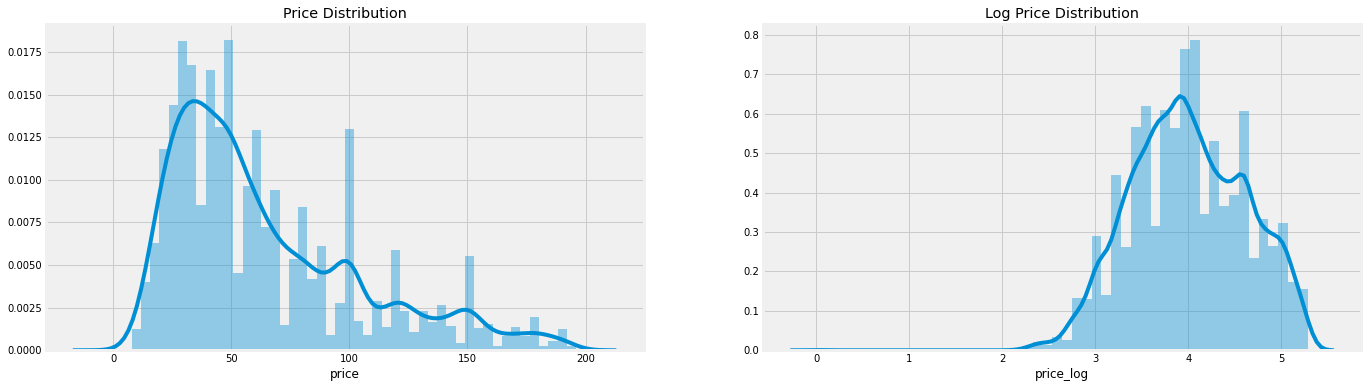

In [4]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(clean_sum_listings['price'], ax=axes[0])
axes[0].set_title('Price Distribution')
sns.distplot(np.log1p(clean_sum_listings['price']), ax=axes[1])
axes[1].set_xlabel('price_log')
axes[1].set_title('Log Price Distribution')

Text(0.5, 1.0, 'Min_nights Log Distribution')

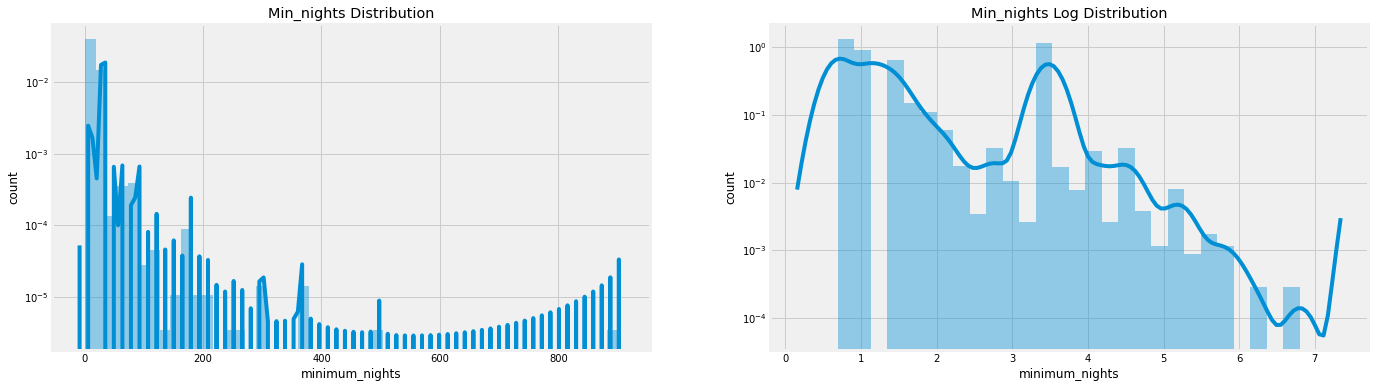

In [5]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(clean_sum_listings['minimum_nights'], ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum_nights')
axes[0].set_ylabel('count')
axes[0].set_title('Min_nights Distribution')


sns.distplot(np.log1p(clean_sum_listings['minimum_nights']), ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum_nights')
axes[1].set_ylabel('count')
axes[1].set_title('Min_nights Log Distribution')

In [6]:
# Applying the logarithmic transformation to the highly skewed features 
clean_sum_listings['price_log'] = np.log1p(clean_sum_listings['price'])
clean_sum_listings['minimum_nights'] = np.log1p(clean_sum_listings['minimum_nights'])

### 1.2 Feature Selection

In [7]:
# dropping columns which will not be used in the Model 
clean_sum_listings = clean_sum_listings.drop(columns=['Unnamed: 0', 'name','host_id','price'])
clean_sum_listings.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

### 2.  Correlation Matrix

In [8]:
def heatmap_ml (df):
    corr = df.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 8))

        ax = sns.heatmap(corr, cmap = 'RdBu_r', annot=True,  mask=mask, vmax=1, vmin= -1, square=True)

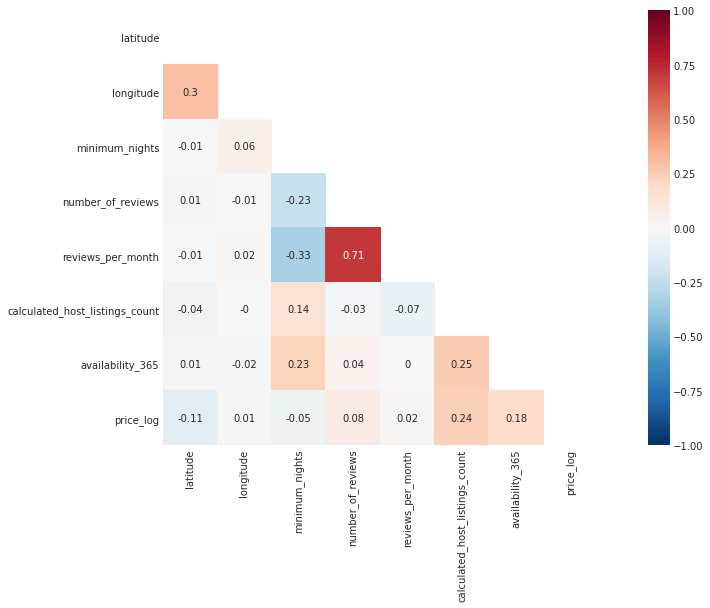

In [9]:
corr_matrix = heatmap_ml (clean_sum_listings)
corr_matrix

- The correlation matrix shows that there is no strong relationship between price and other features 
- The strongest pairs are **reviews_per_month/number_of_reviews** (0.71), **longitude/latitutde** (0.3) and **reviews_per_month/minimum_nights** (-0.26)
- This indicates no further features need to be taken before using training our model

### 3. Enconding Features

In [10]:
categorical_features = clean_sum_listings.select_dtypes(include=['object'])
categorical_features_one_hot = pd.get_dummies(categorical_features)

numerical_features =  clean_sum_listings.select_dtypes(exclude=['object'])
y = numerical_features.price_log
numerical_features = numerical_features.drop(['price_log'], axis=1)

In [11]:
# setting feature (x) and target (y) variable
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

data = pd.concat([X, y], axis = 1)

### 4. Train and Test Split 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

### 5. Feature Scaling

In [13]:
# RobustScaler helps scaling features using statistics that are robust to outliers

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### 6. Machine Learning

### 6.1 K-Fold Cross Validation

- Starting by scorig models using K-fold cross-validation with 5 folds - R2 and Mean Squared Error metrics will be used
- These will be our base models from which we will define our strategy and identify those which might have the best performance predicting the price of our listings
- GridSearchCV algorithm will be used to find the best parameters and tuning hyperparameters for each model

In [14]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 42).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

In [15]:
def rmse_cv_mse(model):
    kf = KFold(n_folds, shuffle=True, random_state = 42).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

### 6.2 Scoring basic models

In [16]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, SVR, SGDRegressor, HuberRegressor]:
    
    cv_res = rmse_cv(Model())
    cv_err = rmse_cv_mse(Model())
    print('{}: {:.5f} +/- {:5f} / '.format(Model.__name__, -cv_res.mean(), cv_res.std()), cv_err.mean())

LinearRegression: -0.40231 +/- 0.010311 /  -0.22065003375662506
Ridge: -0.40266 +/- 0.010364 /  -0.2205184260927136
Lasso: 0.00019 +/- 0.000098 /  -0.3692926550284195
ElasticNet: 0.00019 +/- 0.000098 /  -0.3692926550284195
RandomForestRegressor: -0.53162 +/- 0.005707 /  -0.17268029472652338
SVR: -0.46849 +/- 0.007820 /  -0.1962121345849224
SGDRegressor: -0.39401 +/- 0.011075 /  -0.22487410611087494


/home/dinisoliveira16/.local/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/dinisoliveira16/.local/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/dinisoliveira16/.local/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

HuberRegressor: -0.39925 +/- 0.012279 /  -0.2217730213331976


/home/dinisoliveira16/.local/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### 6.3 Prediction (no parameter tuning)

In [17]:
##Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

#Ridge Model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)             
pred_ridge = ridge_model.predict(X_test) 

#RandomForrestRegressor Model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train) 
pred_test_rf= model_rf.predict(X_test)

#SVR Model
model_svr = SVR()
model_svr.fit(X_train, y_train) 
pred_test_svr= model_svr.predict(X_test)

#SGDRegressor Model
model_sgd = SGDRegressor()
model_sgd.fit(X_train, y_train) 
pred_test_sgd= model_sgd.predict(X_test)

#HuberRegressor Model
model_hr = HuberRegressor()
model_hr.fit(X_train, y_train) 
pred_test_hr= model_hr.predict(X_test)

/home/dinisoliveira16/.local/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [19]:
print('----------Linear Regression ---------------')
print('MAE: %f'% mean_absolute_error(y_test, lr_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2 %f' % r2_score(y_test, lr_pred))

print('---------------Ridge ---------------------')
print('MAE: %f'% mean_absolute_error(y_test, pred_ridge))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred_ridge)))   
print('R2 %f' % r2_score(y_test, pred_ridge))

print('---------------RandomForrestRegressor--------')
print('MAE: %f' % mean_absolute_error(y_test,pred_test_rf)) 
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 %f' % r2_score(y_test, pred_test_rf))

print('---------------SVR Model----------------------')
print('MAE: %f' % mean_absolute_error(y_test,pred_test_svr))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_svr))) 
print('R2 %f' % r2_score(y_test, pred_test_svr))

print('---------------SGDRegressor Model-------------')
print('MAE: %f' % mean_absolute_error(y_test,pred_test_sgd))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_sgd)))
print('R2 %f' % r2_score(y_test, pred_test_sgd))

print('---------------HuberRegressor Model------------')
print('MAE: %f' % mean_absolute_error(y_test,pred_test_hr))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_hr)))
print('R2 %f' % r2_score(y_test, pred_test_hr))

----------Linear Regression ---------------
MAE: 0.377648
RMSE: 0.480733
R2 0.393920
---------------Ridge ---------------------
MAE: 0.377674
RMSE: 0.480697
R2 0.394012
---------------RandomForrestRegressor--------
MAE: 0.342203
RMSE: 0.451869
R2 0.464516
---------------SVR Model----------------------
MAE: 0.353762
RMSE: 0.460725
R2 0.443320
---------------SGDRegressor Model-------------
MAE: 0.379392
RMSE: 0.482111
R2 0.390441
---------------HuberRegressor Model------------
MAE: 0.375754
RMSE: 0.482324
R2 0.389903


### 7. Hyperparameter Tuning - Random Forest

In [20]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use BASE MODEL:\n')
pprint(model_rf.get_params())

Parameters currently in use BASE MODEL:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [21]:
# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

### 7.1 Random Hyperparameter Grid

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#n_estimators = [50, 70, 80, 90, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
#max_depth.append(None)
#max_depth = [None, 25, 50]

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


### Random Search Training

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [24]:
# best parameters from fitting the random search
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

### Evaluation

In [ ]:
#RandomForrestRegressor BaseModel
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train) 
pred_test_rf= model_rf.predict(X_test)

In [ ]:
#RandomForrestRegressor TunedModel
best_random = RandomForestRegressor(n_estimators= 400, min_samples_split=4,min_samples_leaf=2,
                                    max_features= 'auto',max_depth=20, bootstrap= True)
best_random.fit(X_train, y_train) 
pred_test_best_random= best_random.predict(X_test)

In [ ]:
print('---------------RandomForrestRegressor BaseModel-------------------')

print('MAE: %f' % mean_absolute_error(y_test,pred_test_rf)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_rf))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_rf))

print('---------------RandomForrestRegressor TunedModel-------------------')

print('MAE: %f' % mean_absolute_error(y_test,pred_test_best_random)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_best_random))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_best_random))

- The following attempts were made trying the different parameters and all results were gathered below

In [ ]:
# {'n_estimators': 700,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 50,
#  'bootstrap': True}

# ---------------RandomForrestRegressor BaseModel-------------------
# MAE: 0.312153
# RMSE: 0.421678
# R2 0.533681
# ---------------RandomForrestRegressor TunedModel-------------------
# MAE: 0.309980
# RMSE: 0.418886
# R2 0.539835

# R2 diff = 0.006154

# ---

# {'n_estimators': 850,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

# ---------------RandomForrestRegressor BaseModel-------------------
# MAE: 0.310067
# RMSE: 0.418692
# R2 0.540261
# ---------------RandomForrestRegressor TunedModel-------------------
# MAE: 0.310642
# RMSE: 0.419237
# R2 0.539065

# R2 diff = -0.001196

# ---

# {'n_estimators': 1000,
#  'min_samples_split': 4,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 30,
#  'bootstrap': True}

# R2 

# ---

# {'n_estimators': 700,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}


# ---------------RandomForrestRegressor BaseModel-------------------
# MAE: 0.310067
# RMSE: 0.418692
# R2 0.540261
# ---------------RandomForrestRegressor TunedModel-------------------
# MAE: 0.309581
# RMSE: 0.418315
# R2 0.541090

# R2 diff = 0,000829

### Grid Search with Cross Validation

- After getting an idea of the ranges that yielded the best results, we proceed with a GridSearchCV to attempt different combinations of tuning to achieve better performance results

In [25]:
# {'n_estimators': 700,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

# R2 0.541090

# {'n_estimators': 700,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 50,
#  'bootstrap': True}

# R2 0.539835


# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [700],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'max_depth': [5, 50, 100],
    'bootstrap': [True]

}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [26]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.4min remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.0min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 700}

In [27]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [28]:
pred_test_best_grid = best_grid.predict(X_test)

In [29]:
print('---------------GridSearch Best-Grid-------------------')

print('MAE: %f' % mean_absolute_error(y_test,pred_test_best_grid)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_best_grid))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_best_grid))

---------------GridSearch Best-Grid-------------------
MAE: 0.341384
RMSE: 0.450923
R2 0.466756


In [ ]:
# another round of GridSearchCV

In [30]:
# {'bootstrap': True,
#  'max_depth': 50,
#  'max_features': 'auto',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 700}


param_grid = {
    'bootstrap': [True],
    'max_depth': [50],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [10, 30, 100]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [31]:
# Fit the grid search to the data
grid_search_final = grid_search_final.fit(X_train, y_train)
grid_search_final.best_params_

# grid_search_final.fit(X_train, y_train)
# grid_search_final.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.7s finished


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [32]:
grid_search_final = grid_search_final.best_estimator_
grid_search_final

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [33]:
pred_test_grid_search_final = grid_search_final.predict(X_test)

In [34]:
print('---------------GridSearch Final-------------------')

print('MAE: %f' % mean_absolute_error(y_test,pred_test_grid_search_final)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_grid_search_final))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_grid_search_final))

---------------GridSearch Final-------------------
MAE: 0.340811
RMSE: 0.449964
R2 0.469021


- The option that seems to be fitting the model the best is using the following parameters
- The R2 score is the highest from all the combinations used so this will be considered the final combination

In [38]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [43]:
# Fit the grid search to the data
final = final.fit(X_train, y_train)
pred_final = final.predict(X_test)

In [46]:
# ---------------GridSearch Final-------------------
# MAE: 0.342351
# RMSE: 0.418133
# R2 0.544570

### Modern Models

- As a future development, the next possible iteration to attempt are modern regressors such as XGBRegressor and LGBMRegressor which have become very popular among Kaggle competitions for their fast processing and higher results
- Two additional strategies can be adding more complexity (extra features) via a Polynomial Transformation or trying to predict prices through a meta regressor (stacking multiple models through StackingCVRegressor)

### XGBRegressor

In [35]:
import xgboost as xgboost

xgb = xgboost.XGBRegressor(n_estimators=700,learning_rate=0.1,objective='reg:squarederror')
xgb = xgboost.XGBRegressor(objective='reg:squarederror')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [36]:
print('---------------XGBRegressor-------------------')

print('MAE: %f' % mean_absolute_error(y_test,xgb_pred)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,xgb_pred))) #RMSE
print('R2 %f' % r2_score(y_test, xgb_pred))

---------------XGBRegressor-------------------
MAE: 0.352518
RMSE: 0.456854
R2 0.452636


In [37]:
from sklearn.model_selection import KFold, cross_val_score


xgb_baseline = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)

n_folds = 5

kf = KFold(n_folds, shuffle=True, random_state = 42).get_n_splits(numerical_features)

cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)

y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)

[15:51:06] WARNING: /home/dinisoliveira16/build/xgboost/python-package/build/temp.linux-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:51:15] WARNING: /home/dinisoliveira16/build/xgboost/python-package/build/temp.linux-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:51:23] WARNING: /home/dinisoliveira16/build/xgboost/python-package/build/temp.linux-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping } might

In [47]:
print('---------------XGBRegressor Base-------------------')

print('MAE: %f' % mean_absolute_error(y_test,y_test_xgb_base)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,y_test_xgb_base))) #RMSE
print('R2 %f' % r2_score(y_test, y_test_xgb_base))

---------------XGBRegressor Base-------------------
MAE: 0.350601
RMSE: 0.453460
R2 0.460739


In [49]:
# from lightgbm import LGBMRegressor

In [ ]:
clean_sum_listings.columns

In [ ]:
clean_sum_listings.dtypes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
categorical_features_one_hot

In [ ]:
def transform_data(df, num_cols, cat_cols):
    transformed_df = df.copy()

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)
    #transformed_df[num_cols] = transformed_df[num_cols].apply(lambda x: np.log1p(x))

    num_cols.drop('pricelog')
    scaler = MinMaxScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])

    return transformed_df

In [ ]:
X_train.columns = X_train.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [ ]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]

In [ ]:
X_train.columns

In [ ]:
model = LGBMRegressor()

model.fit(X_train, y_train)  
y_test_lgbm = model.predict(X_test) 

print('---------------LGBMRegressor-------------------')

print('MAE: %f' % mean_absolute_error(y_test,y_test_lgbm)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,y_test_lgbm))) #RMSE
print('R2 %f' % r2_score(y_test, y_test_lgbm))

In [ ]:
model = LGBMRegressor()

model.fit(X_train, y_train)  
y_test_lgbm = model.predict(X_test) 

print('---------------LGBMRegressor-------------------')

print('MAE: %f' % mean_absolute_error(y_test,y_test_lgbm)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,y_test_lgbm))) #RMSE
print('R2 %f' % r2_score(y_test, y_test_lgbm))

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(X_train, y_train)  
y_test_svr = svr.predict(X_test) 

print('---------------LGBMRegressor-------------------')

print('MAE: %f' % mean_absolute_error(y_test,y_test_svr)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,y_test_svr))) #RMSE
print('R2 %f' % r2_score(y_test, y_test_svr))

In [ ]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

RANDOM_SEED = 42

svr = SVR(kernel='linear')
lasso = Lasso()
rf = RandomForestRegressor(n_estimators=5, 
                           random_state=RANDOM_SEED)

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
stack = StackingCVRegressor(regressors=(svr, lasso, rf),
                            meta_regressor=lasso,
                            random_state=RANDOM_SEED)

print('5-fold cross validation scores:\n')

for clf, label in zip([svr, lasso, rf, stack], ['SVM', 'Lasso', 
                                                'Random Forest', 
                                                'StackingCVRegressor']):
    scores = cross_val_score(clf, X, y, cv=5)
    print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (
        scores.mean(), scores.std(), label))

In [ ]:
models = [LinearRegression, Ridge, Lasso, ElasticNet, SVR, RandomForestRegressor]
stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

y_pred_stack=stack.predict(X_test.values)    